In [1]:
import os
import warnings
import time
import sys
import pickle
import seaborn as sns
import lightgbm as lgb
import numpy as np
import pandas as pd
from bayes_opt import BayesianOptimization, SequentialDomainReductionTransformer
from skopt  import BayesSearchCV 
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
from importlib import reload
import binary_output, run_models, process_df
from binary_output import calc_binary_metrics, calc_confusion_values, get_binary_metrics_for_threshold, get_binary_cv_metrics, get_print_binary_metrics
from run_models import get_classification_cv_predictions, get_df_work_columns
from process_df import split_df
reload(binary_output)
reload(run_models)
reload(process_df)
from binary_output import calc_binary_metrics, calc_confusion_values, get_binary_metrics_for_threshold, get_binary_cv_metrics, get_print_binary_metrics
from run_models import get_classification_cv_predictions, get_df_work_columns
from process_df import split_df

In [26]:
# df_full = pd.read_csv('outliers/final/df.csv', index_col='id')

# def set_profit(dataset):
#     df = df_full.loc[dataset.index]
#     return df.META__revenue > df.budget

# y_train, y_val, y_test = set_profit(y_train), set_profit(y_val), set_profit(y_test)

# with open(f'outliers/final/nan_filled_data.pickle', 'rb') as handle:
#    data = pickle.load(handle)

# X_train, X_val, X_test = data['X_train'], data['X_val'], data['X_test']

# X = pd.concat([X_train, X_test, X_val])
# y = np.concatenate([y_train, y_test, y_val])

# data_binary = {'X_train': X_train, 'X_val': X_val, 'X_test': X_test, 'y_train': y_train, 'y_val': y_val, 'y_test': y_test}
# with open(f'classification/binary_data_dropped_nan_filled.pickle', 'wb') as handle:
#    pickle.dump(data_binary, handle)

In [27]:
with open(f'classification/binary_data_dropped_nan_filled.pickle', 'rb') as handle:
    data = pickle.load(handle)

X_train, y_train, X_val, y_val, X_test, y_test = data['X_train'], data['y_train'], data['X_val'], data['y_val'], data['X_test'], data['y_test']
X = pd.concat([X_train, X_test, X_val])
y = np.concatenate([y_train, y_test, y_val])

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import TransformedTargetRegressor

In [29]:
def create_lgb(params={}):
    def_params = {
        'bagging_fraction': 0.9320921709538026,
        'feature_fraction': 0.9108988200799922,
        'learning_rate': 0.036716125518746354,
        'max_bin': 153,
        'max_depth': 79,
        'min_data_in_leaf': 70,
        'min_sum_hessian_in_leaf': 25.77863726071913,
        'n_estimators': 8099,
        'num_leaves': 88,
        'subsample': 0.34664932012113514,
        'objective': 'binary',
        'metric': 'auc',
        'is_unbalance': True,
        'boost_from_average': False,
    }
    def_params.update(params)
    return lgb.LGBMClassifier(**def_params)

def fit_lgb(model, X, y, X_val=None, y_val=None, eval_metric='auc', patience=100):
    eval_set = (X_val, y_val) if not X_val.empty and y_val.any() else None
    fit_params = {'early_stopping_rounds': patience} if eval_set else {}
    return model.fit(X.values, y, verbose=-1, eval_metric=eval_metric, eval_set=eval_set, **fit_params)

def create_and_fit_lgb(X, y, X_val=None, y_val=None, eval_metric='auc', patience=100):
    return fit_lgb(create_lgb(), X, y, X_val, y_val, eval_metric, patience=patience)

def create_and_fit_lgb_pipe(X, y, X_val=None, y_val=None, eval_metric='auc', patience=100):
    pipe = Pipeline([
            ('powertransform', PowerTransformer()),
            ('model', create_lgb()),
        ])

    fit_params = {'model__verbose': -1}
    eval_set = (X_val, y_val) if not X_val.empty and y_val.any() else None
    if eval_set:
        fit_params['model__early_stopping_rounds'] = patience
        fit_params['model__eval_metric'] = eval_metric
        fit_params['model__eval_set'] = eval_set
    pipe = pipe.fit(X.values, y, **fit_params)
    return pipe

In [30]:
# with open(f'classification/binary_data_dropped.pickle', 'rb') as handle:
#    data = pickle.load(handle)

# X_train, y_train, X_val, y_val, X_test, y_test = data['X_train'], data['y_train'], data['X_val'], data['y_val'], data['X_test'], data['y_test']

# X = pd.concat([X_train, X_test, X_val])
# y = np.concatenate([y_train, y_test, y_val])

###################################
split num: 1
train shape (5954, 228), val shape (314, 228), test shape (697, 228)
train not profit 4140, val not profit 220, test not profit 485
[LightGBM] [Warning] bagging_fraction is set=0.62, subsample=0.5 will be ignored. Current value: bagging_fraction=0.62
[LightGBM] [Warning] feature_fraction is set=0.64, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.64
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=28, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's auc: 0.820479
###################################
split num: 2
train shape (5954, 228), val shape (314, 228), test shape (697, 228)
train not profit 4146, val not profit 214, test not profit 485
[LightGBM

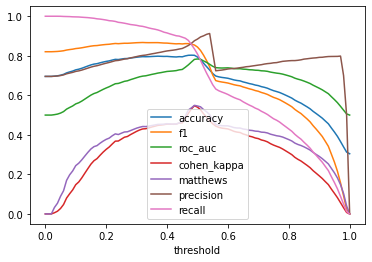

tp: max 484.5 at threshold 0.0
tp: min 0.0 at threshold 1.0
tn: max 212.0 at threshold 0.98
tn: min 0.0 at threshold 0.0
fp: max 212.0 at threshold 0.0
fp: min 0.0 at threshold 0.98
fn: max 484.5 at threshold 1.0
fn: min 0.0 at threshold 0.0
error_rate: max 484.5 at threshold 1.0
error_rate: min 137.2 at threshold 0.48


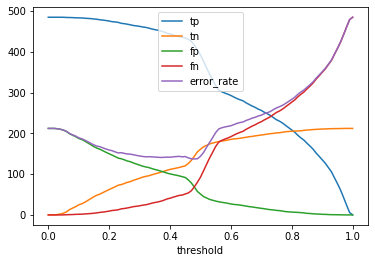

In [63]:
prediction, _ = get_classification_cv_predictions(create_and_fit_lgb, X, y, n_splits=10, patience=30)
pred_metrics = get_binary_cv_metrics(prediction)

In [60]:
# no power transformed data, new hyperparams
get_binary_metrics_for_threshold(pred_metrics, 0.49)

accuracy: 0.8133550602747407
f1: 0.8624288195526532
roc_auc: 0.7950095730161512
cohen_kappa: 0.5725773349804434
matthews: 0.5749250233055851
precision: 0.884491064278141
recall: 0.8419059384851325
tn: 158.6
fp: 53.4
fn: 76.6
tp: 407.9
error_rate: 130.0


In [68]:
def convert_lgb_classifier_parameters(params):
    get_float = lambda val: max(min(val, 1), 0)
    get_int = lambda val: int(round(val))

    return_params = {
        'application': 'binary',
        'metric': 'auc',
        'is_unbalance': True,
        'boost_from_average': False,
        'verbose': -1,
        'random_state': 0,
        'reg_lambda': params['reg_lambda'],
        'min_sum_hessian_in_leaf': params['min_sum_hessian_in_leaf'],
    }

    int_params = ['num_leaves', 'max_depth', 'max_bin', 'n_estimators', 'min_child_samples', 'min_data_in_leaf', 'bagging_freq']
    float_params = ['learning_rate', 'min_child_weight', 'subsample', 'colsample_bytree', 'reg_alpha', 'bagging_fraction', 'feature_fraction']
    for param in int_params:
        return_params[param] = get_int(params[param])
    for param in float_params:
        return_params[param] = get_float(params[param])
    return return_params

In [75]:
# Fine tune lgb binary classifier with hyperas
from hyperopt import Trials, STATUS_OK, tpe, rand
from hyperas import optim
from hyperas.distributions import choice, uniform

def get_data():
    with open(f'classification/binary_data_dropped_nan_filled.pickle', 'rb') as handle:
        data = pickle.load(handle)

    X_train, y_train, X_val, y_val, X_test, y_test = data['X_train'], data['y_train'], data['X_val'], data['y_val'], data['X_test'], data['y_test']
    X = pd.concat([X_train, X_test, X_val])
    y = np.concatenate([y_train, y_test, y_val])
    return X, y

def get_lgb_hyperas_model(X, y):
    reg_lambda={{uniform(0, 100)}}
    min_sum_hessian_in_leaf={{uniform(0, 100)}}
    num_leaves={{uniform(24, 150)}}
    max_depth={{uniform(10, 100)}}
    max_bin={{uniform(20, 200)}}
    n_estimators={{uniform(1000, 20000)}}
    min_child_samples={{uniform(1, 250)}}
    min_data_in_leaf={{uniform(1, 80)}}
    learning_rate={{uniform(0.01, 1.0)}}
    min_child_weight={{uniform(0.1, 0.5)}}
    subsample={{uniform(0.1, 1.0)}}
    colsample_bytree={{uniform(0.01, 1)}}
    reg_alpha={{uniform(0, 1)}}
    bagging_fraction={{uniform(0.5, 1)}}
    bagging_freq={{uniform(0, 100)}}
    feature_fraction={{uniform(0.6, 1.0)}}
   
    params_raw = {
        'reg_lambda': reg_lambda,
        'min_sum_hessian_in_leaf': min_sum_hessian_in_leaf,
        'num_leaves': num_leaves,
        'max_depth': max_depth,
        'max_bin':max_bin,
        'n_estimators': n_estimators,
        'min_child_samples': min_child_samples,
        'min_data_in_leaf': min_data_in_leaf,
        'learning_rate': learning_rate,
        'min_child_weight': min_child_weight,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'reg_alpha': reg_alpha,
        'bagging_fraction': bagging_fraction,
        'bagging_freq': bagging_freq,
        'feature_fraction': feature_fraction,
    }
    params = convert_lgb_classifier_parameters(params_raw)
    # print(params)
    train_data = lgb.Dataset(data=X, label=y, free_raw_data=False)
    cv_result = lgb.cv(params, train_data, nfold=10, seed=0, stratified=True, verbose_eval=500, metrics=['auc'], early_stopping_rounds=30)
    return {'loss': -max(cv_result['auc-mean']), 'status': STATUS_OK}

In [76]:
best_run = None
best_model = None
space = None
trials=Trials()
best_run, best_model, space = optim.minimize(model=get_lgb_hyperas_model,
                                      data=get_data,
                                      algo=tpe.suggest,
                                      max_evals=200,
                                      trials=trials,
                                      notebook_name='classification_lgm',
                                      eval_space=True,
                                      return_space=True,
                                      functions=[convert_lgb_classifier_parameters])

>>> Imports:
#coding=utf-8

try:
    import os
except:
    pass

try:
    import warnings
except:
    pass

try:
    import time
except:
    pass

try:
    import sys
except:
    pass

try:
    import pickle
except:
    pass

try:
    import seaborn as sns
except:
    pass

try:
    import lightgbm as lgb
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    from bayes_opt import BayesianOptimization, SequentialDomainReductionTransformer
except:
    pass

try:
    from skopt import BayesSearchCV
except:
    pass

try:
    from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
except:
    pass

try:
    from importlib import reload
except:
    pass

try:
    import binary_output, run_models, process_df
except:
    pass

try:
    from binary_output import calc_binary_metrics, calc_confusion_values, get_binary_metrics_for_threshold, get_binary_cv_metrics, get_print_binary_metrics
except:
    

In [85]:
best_run

{'bagging_fraction': 0.9954883020832686,
 'colsample_bytree': 0.3662098825802015,
 'feature_fraction': 0.7430773954715099,
 'learning_rate': 0.026388197123065102,
 'max_bin': 39.79397597851593,
 'max_depth': 27.26929677358449,
 'min_child_samples': 22.59785176954276,
 'min_child_weight': 0.15057786553957786,
 'min_data_in_leaf': 9.505482443720242,
 'n_estimators': 2829.1734388524605,
 'num_leaves': 131.39750262339348,
 'reg_alpha': 0.14479543771682674,
 'reg_lambda': 19.67367721957657,
 'reg_lambda_1': 17.89309933200306,
 'reg_lambda_2': 77.03889966019966,
 'subsample': 0.37685634473354657,
 'min_sum_hessian_in_leaf': 0}

In [86]:
best_run['min_sum_hessian_in_leaf'] = 0
best_run['bagging_freq'] = 0

In [87]:
print_formatted_params(best_run)

application='binary',
metric='auc',
is_unbalance=True,
boost_from_average=False,
verbose=-1,
random_state=0,
reg_lambda=19.674,
min_sum_hessian_in_leaf=0,
num_leaves=131,
max_depth=27,
max_bin=40,
n_estimators=2829,
min_child_samples=23,
min_data_in_leaf=10,
bagging_freq=0,
learning_rate=0.026,
min_child_weight=0.151,
subsample=0.377,
colsample_bytree=0.366,
reg_alpha=0.145,
bagging_fraction=0.995,
feature_fraction=0.743,


In [18]:
# Fine tune lgb binary classifier with bayesian optimization
def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=30, n_folds=5, random_seed=0, output_process=False):
    train_data = lgb.Dataset(data=X, label=y, free_raw_data=False)
    def model_eval(**params_raw):
        params = convert_lgb_classifier_parameters(params_raw)
        # print(params)
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval=500, metrics=['auc'], early_stopping_rounds=30)
        return max(cv_result['auc-mean'])

    pbounds = {
        'reg_lambda': (0, 100),
        'min_sum_hessian_in_leaf': (0, 100),
        'num_leaves': (24, 150),
        'max_depth': (10, 100),
        'max_bin':(20,200),
        'n_estimators': (1000, 20000),
        'min_child_samples': (1, 250),
        'min_data_in_leaf': (1, 80),
        'learning_rate': (0.01, 1.0),
        'min_child_weight': (0.1, 0.5),
        'subsample': (0.1, 1.0),
        'colsample_bytree': (0.01, 1.0),
        'reg_alpha': (0, 1),
        'bagging_fraction': (0.5, 1.0),
        'bagging_freq': (0, 100),
        'feature_fraction': (0.6, 1.0),
    }

    bounds_transformer = SequentialDomainReductionTransformer()
    optimizer = BayesianOptimization(
        f = model_eval, 
        pbounds = pbounds, 
        random_state=0,
        bounds_transformer=bounds_transformer,
    )
    optimizer.maximize(init_points=init_round, n_iter=opt_round)
    model_params=[]
    for model in range(len(optimizer.res)):
        model_params.append(optimizer.res[model]['target'])
    return {
        'target': optimizer.res[pd.Series(model_params).idxmax()]['target'], 
        'params': optimizer.res[pd.Series(model_params).idxmax()]['params'],
        'bounds_transformer': bounds_transformer,
        'optimizer': optimizer,
    }

In [19]:
%%time
lgb_optimized = bayes_parameter_opt_lgb(X, y, init_round=2, opt_round=50, n_folds=10, random_seed=0)

|   iter    |  target   | baggin... | baggin... | colsam... | featur... | learni... |  max_bin  | max_depth | min_ch... | min_ch... | min_da... | min_su... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.8675   |  0.7744   |  71.52    |  0.6067   |  0.818    |  0.4294   |  136.3    |  49.38    |  223.1    |  0.4855   |  31.29    |  79.17    |  1.105e+0 |  95.57    |  0.9256   |  7.104    |  0.1784   |
|  2        |  0.8456   |  0.5101   |  83.26    |  0.7804   |  0.948    |  0.9788   |  163.8    |  51.53    |  195.4    |  0.1473   |  51.55    |  14.34    |  1.895e+0 |  89.75    |  0.4147   |  26.46    |  0.7968   |
[500]	cv_agg's auc: 0.884366 + 0.00622375
|  3        |  0.8845   |  0.8896   |  52.72    |  0.3429   |  0.8009   |  0.0772   | 

In [36]:
print_formatted_params(lgb_optimized['params'])

application='binary',
metric='auc',
is_unbalance=True,
boost_from_average=False,
verbose=-1,
random_state=0,
reg_lambda=55.442,
min_sum_hessian_in_leaf=76.284,
num_leaves=85,
max_depth=26,
max_bin=47,
n_estimators=15196,
min_child_samples=177,
min_data_in_leaf=13,
bagging_freq=49,
learning_rate=0.165,
min_child_weight=0.463,
subsample=0.564,
colsample_bytree=0.333,
reg_alpha=0.591,
bagging_fraction=0.973,
feature_fraction=0.706,


In [35]:
def print_formatted(obj):
    for p in obj:
        val = obj[p]
        if isinstance(val, float):
            val = round(val, 3)
        elif isinstance(val, str):
            val = f'\'{val}\''
        print(f'{p}={val},')

def print_output(obj):
    for p in obj:
        print(f'{p}: {obj[p]}')
   
def print_formatted_params(params):
    print_formatted(convert_lgb_classifier_parameters(params))

In [88]:
# Test lgb
def create_test_lgb():
    return lgb.LGBMClassifier(
        application='binary',
        metric='auc',
        is_unbalance=True,
        boost_from_average=False,
        verbose=-1,
        random_state=0,
        reg_lambda=55.442,
        min_sum_hessian_in_leaf=76.284,
        num_leaves=85,
        max_depth=26,
        max_bin=47,
        n_estimators=15196,
        min_child_samples=177,
        min_data_in_leaf=13,
        bagging_freq=49,
        learning_rate=0.165,
        min_child_weight=0.463,
        subsample=0.564,
        colsample_bytree=0.333,
        reg_alpha=0.591,
        bagging_fraction=0.973,
        feature_fraction=0.706,
    )

def create_and_fit_test_lgb(X, y, X_val=None, y_val=None, eval_metric='auc', patience=30):
    return fit_lgb(create_test_lgb(), X, y, X_val, y_val, eval_metric, patience=patience)

###################################
split num: 1
train shape (5954, 228), val shape (314, 228), test shape (697, 228)
train not profit 4139, val not profit 221, test not profit 485
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[9]	valid_0's auc: 0.825816
###################################
split num: 2
train shape (5954, 228), val shape (314, 228), test shape (697, 228)
train not profit 4144, val not profit 216, test not profit 485
[LightGBM] [Warning] bagging_fraction is set=0.995, subsample=0.377 will be ignored. Current value: bagging_fraction=0.995
[LightGBM] [Warning] feature_fraction is set=0.743, colsample_bytree=0.366 will be ignored. Current value: feature_fraction=0.743
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=10
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[133]	valid_0's auc: 0.895975
#############

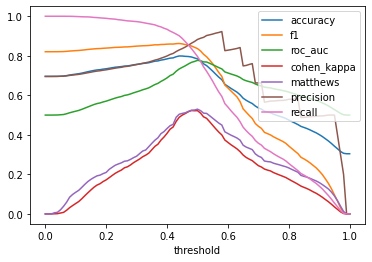

tp: max 484.5 at threshold 0.0
tp: min 0.0 at threshold 0.99
tn: max 212.0 at threshold 0.93
tn: min 0.0 at threshold 0.0
fp: max 212.0 at threshold 0.0
fp: min 0.0 at threshold 0.93
fn: max 484.5 at threshold 0.99
fn: min 0.0 at threshold 0.0
error_rate: max 484.5 at threshold 0.99
error_rate: min 140.0 at threshold 0.44


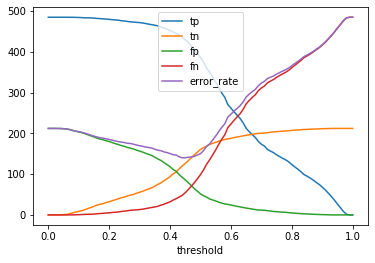

In [89]:
prediction, _ = get_classification_cv_predictions(create_and_fit_test_lgb, X, y, n_splits=10, patience=10)
pred_metrics = get_binary_cv_metrics(prediction)

In [90]:
# no power transformed data, new hyperparams
get_binary_metrics_for_threshold(pred_metrics, 0.5)

accuracy: 0.7845002803476311
f1: 0.8363949427355418
roc_auc: 0.7767909095731769
cohen_kappa: 0.5225323888024386
matthews: 0.5299365061297914
precision: 0.8825095222473358
recall: 0.7965063474482406
tn: 160.5
fp: 51.5
fn: 98.6
tp: 385.9
error_rate: 150.1


accuracy: max 0.8189655172413793 at threshold 0.35
accuracy: min 0.2916666666666667 at threshold 1.0
f1: max 0.879162702188392 at threshold 0.3
f1: min 0.0 at threshold 1.0
roc_auc: max 0.797594900028977 at threshold 0.69
roc_auc: min 0.5 at threshold 0.0
cohen_kappa: max 0.5556821418399316 at threshold 0.52
cohen_kappa: min 0.0 at threshold 0.0
matthews: max 0.5563565251587426 at threshold 0.53
matthews: min 0.0 at threshold 0.0
precision: max 0.9945945945945946 at threshold 0.94
precision: min 0.0 at threshold 1.0
recall: max 1.0 at threshold 0.0
recall: min 0.0 at threshold 1.0


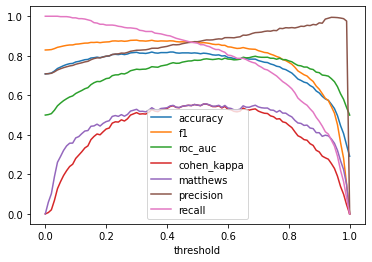

tn: max 203 at threshold 1.0
tn: min 0 at threshold 0.0
fp: max 203 at threshold 0.0
fp: min 0 at threshold 1.0
fn: max 493 at threshold 1.0
fn: min 0 at threshold 0.0
tp: max 493 at threshold 0.0
tp: min 0 at threshold 1.0
error_rate: max 493 at threshold 1.0
error_rate: min 126 at threshold 0.35


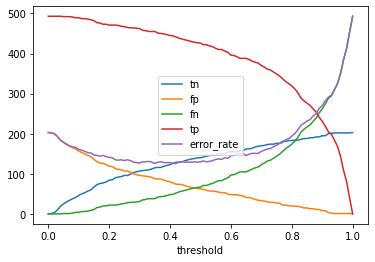

In [13]:
y_pred = mod_lgb.predict_proba(X_test)
pred_metrics = get_print_binary_metrics(y_test, y_pred)